In [1]:
import numpy as np 
# -- local --
import env
import hogg as Hogg
# -- plotting -- 
from corner import corner
import matplotlib.pyplot as plt 
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
%matplotlib inline

## Toy-"experiment" to test Gaussian $\mathcal{L}_{gauss}$, ABC, and ICA
We begin with the comparison in Hogg (in prep?) and follow Hogg's notations

Let data be drawn from a normal distribution with True mean $\mu = 7.0$ and True variance $V = 17.0$: 

In [40]:
Truth = np.array([7., 17.])
N = 5

In [41]:
np.random.seed(7)
data = Hogg.hoggdraw(Truth, N)

This data has 

In [42]:
mu_emp = np.mean(data)
var_emp = Hogg.hoggvar(data)
print 'mu = ', mu_emp, 'var = ', var_emp

mu =  7.72236954977 var =  15.7719421168


The correct likelihood for $\{ y_n\}$ can be written as
$$ ln \; p(\{y_n\}|\mu, V) = -\frac{1}{2} \sum_{n=1}^{N} \frac{(y_n - \mu)^2}{V} - \frac{N}{2} ln \,V$$
Lets run a MCMC using this correct likelihood

and uniform prior $0 < \mu < 10$ and $0 < V < 100$. 

In [43]:
def ln_correct_likelihood(data, pars):
    mean, var = pars
    return np.sum(-0.5 * (data - mean) ** 2 / var) - (0.5 * len(data) * np.log(var))

In [44]:
def ln_prior(pars, prior_info): 
    mean, var = pars
    if mean < prior_info[0]: 
        return -np.Inf
    if mean > prior_info[1]: 
        return -np.Inf
    if mean < prior_info[2]: 
        return -np.Inf
    if mean > prior_info[3]: 
        return -np.Inf
    return 0. 

In [45]:
def ln_correct_posterior(pars, data, prior_info):
    lnp = ln_prior(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_correct_likelihood(data, pars)

In [46]:
def mcmc_step(pars, lnpvalue, lnp, args, stepsizes=None):
    newpars = pars + stepsizes * np.random.normal(size=len(pars))
    newlnpvalue = lnp(newpars, *args)
    if (newlnpvalue - lnpvalue) > np.log(np.random.uniform()):
        return newpars, newlnpvalue
    return pars.copy(), lnpvalue

def mcmc(pars0, lnp, nsteps, args, stepsizes=None):
    pars = pars0.copy()
    lnpvalue = lnp(pars, *args)
    parss = np.zeros((nsteps, len(pars)))
    for k in range(nsteps):
        pars, lnpvalue = mcmc_step(pars, lnpvalue, lnp, args, stepsizes=stepsizes)
        parss[k,:] = pars
    return parss


In [47]:
prior_info = np.array([0., 10., 0., 100.])
stepsizes = np.array([4., 4.])
pars0 = Truth.copy() 
Tbig = 2**19
thinfactor = 2 ** 4
correct_mcmc_samples = mcmc(pars0, ln_correct_posterior, Tbig, (data, prior_info, ), stepsizes=stepsizes)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [48]:
accept = correct_mcmc_samples[1:] != correct_mcmc_samples[:-1]
print np.mean(accept)
correct_mcmc_samples = correct_mcmc_samples[::thinfactor]
print correct_mcmc_samples.shape

0.480061493037
(32768, 2)


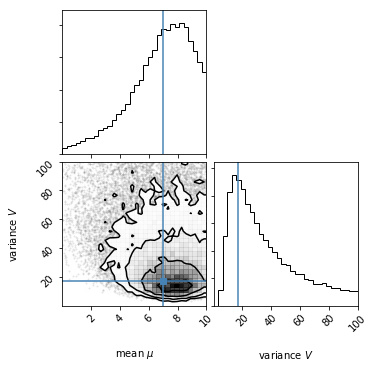

In [49]:
fig = corner(correct_mcmc_samples, bins=32, labels=[r'mean $\mu$', r'variance $V$'], 
             range=[prior_info[0:2], prior_info[2:4]], truths=Truth)

But analogous in spirit as typical cosmological analyses, we will use a pseudo Gaussian likelihood of the for
$$ ln \; p_{pseudo}(s_y^2|V) \propto -\frac{1}{2} \frac{(s_y^2 - V)^2}{\Sigma^2}$$
where $\Sigma^2$ is the empirical variance of variance. For gaussian
$$\Sigma = \frac{2 (s_y^2)^2}{N-1}$$

In [50]:
def ln_pseudo_likelihood(empiricalvar, pars, varvar):
    mean, var = pars
    return (-0.5 * (empiricalvar - var ) ** 2 / varvar)

def ln_pseudo_posterior(pars, empiricalvar, varvar, prior_info):
    lnp = ln_prior(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_pseudo_likelihood(empiricalvar, pars, varvar)

In [51]:
varvar = 2 * var_emp * var_emp / float(N - 1)
pseudo_mcmc_samples = mcmc(pars0, ln_pseudo_posterior, Tbig, (var_emp, varvar, prior_info, ), stepsizes=stepsizes)

In [52]:
accept = pseudo_mcmc_samples[1:] != pseudo_mcmc_samples[:-1]
print "acceptance ratio", np.mean(accept)
pseudo_mcmc_samples = pseudo_mcmc_samples[::thinfactor] # thin
print(pseudo_mcmc_samples.shape)

acceptance ratio 0.605595790092
(32768, 2)


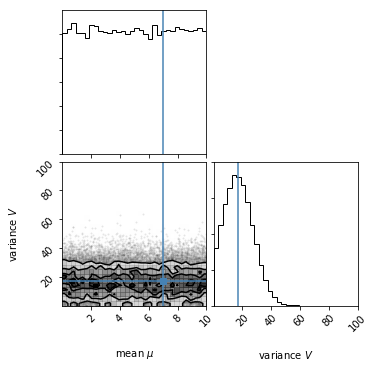

In [53]:
fig = corner(pseudo_mcmc_samples, bins=32, labels=[r'mean $\mu$', r'variance $V$'], 
             range=[prior_info[0:2], prior_info[2:4]], truths=Truth)